In [ ]:
# !pip install fastparquet
# !pip install pytube
# !pip install clip-by-openai
# !pip install -U open-metric-learning
# !pip install -U chromadb
# !pip install pysqlite3-binary

In [1]:
import pandas as pd
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

import clip
from oml.models import ViTUnicomExtractor
from oml.registry.transforms import get_transforms_for_pretrained
from oml.inference.flat import inference_on_images

# for chromadb
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

import chromadb

/media/data/osamoile/cv/image-processing-braille-olehsamoilenko/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet('./data/cctube_106.parquet')
df = df[df.word_count < 100] # to minimise ddos attack on YouTube :)
print(len(df))
df.iloc[0]

10930


video_id                                                        Rw2Yb46QdBI
video_link                      https://www.youtube.com/watch?v=Rw2Yb46QdBI
title                          How this Parisian dog can affect your energy
text                      Fly Me to the Moon let me the [Music] stars in...
channel                                                Susan Chan Feng Shui
channel_id                                         UCnUnvK_ZmmqawZw9aLxjyMw
date                                                             2024-02-21
license                   Creative Commons Attribution license (reuse al...
original_language                                                        en
language_id_method                                                 metadata
transcription_language                                                   en
word_count                                                               27
character_count                                                         121
Name: 2, dty

In [9]:
# download videos

from pytube import YouTube

counter = len(os.listdir('./videos'))
for index, row in df.iterrows():
    if (os.path.isfile('./videos/'+ row.video_id + '.mp4')):
        # file exists
        continue
    if counter >= 1000:
        break
    yt = YouTube(row.video_link)
    if yt.length <= 60:
        try:
            yt = yt.streams.filter(res='360p', file_extension='mp4')
            yt.first().download('./videos/', filename=row.video_id + '.mp4')
            counter += 1
            # progress check
            if counter % 100 == 0:
                print(counter)
        except:
            pass

len(os.listdir('./videos'))

1000

In [3]:
# extract keyframes

import subprocess

for filename in tqdm(os.listdir('./videos')):
    img_filename = './images/' + filename[:-4] + '_%02d.jpg'
    in_file = './videos/' + filename
    # 1 keyframe per 5 seconds
    cmd = ['ffmpeg', '-i', in_file, '-f', 'image2', '-vf', "fps=1/5", '-vsync', 'vfr', img_filename]
    subprocess.run(cmd)

  0%|          | 0/1000 [00:00<?, ?it/s]ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

In [3]:
# clip
model_clip, transform_clip = clip.load("ViT-B/32", device='cpu', jit=False)

# unicom
model_unicom = ViTUnicomExtractor.from_pretrained("vitb32_unicom")
transform_unicom, _ = get_transforms_for_pretrained("vitb32_unicom")

In [4]:
db = chromadb.PersistentClient()
collection_clip = db.get_or_create_collection("clip_osamoile")
collection_unicom = db.get_or_create_collection("unicom_osamoile")

collection_unicom.count(), collection_clip.count()

(5755, 5755)

In [5]:
# fill collections

for filename in tqdm(os.listdir('./images')):
    image = Image.open('./images/' + filename)
    with torch.no_grad():
        # clip
        inputs = transform_clip(image)
        features_clip = model_clip.encode_image(inputs.unsqueeze(0))
        collection_clip.add(filename, features_clip.tolist())

        # unicom
        features_unicom = inference_on_images(
            model_unicom,
            paths=['./images/' + filename],
            transform=transform_unicom,
            num_workers=1,
            batch_size=1)
        collection_unicom.add(filename, features_unicom.tolist())

  0%|          | 0/5755 [00:00<?, ?it/s]/media/data/osamoile/cv/image-processing-braille-olehsamoilenko/.venv/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/media/data/osamoile/cv/image-processing-braille-olehsamoilenko/.venv/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/media/data/osamoile/cv/image-processing-braille-olehsamoilenko/.venv/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  war

In [6]:
def plot_results(df_res, in_query=None):
    f, axarr = plt.subplots(2, 5, figsize=(14, 8))
    axarr[0][0].patch.set_edgecolor('red')
    axarr[0][0].patch.set_linewidth(5)
    axarr[0][0].title.set_text('query')

    res = df_res['ids'][0]
    distance = df_res['distances'][0]

    if in_query:
        in_img = Image.open(in_query)
        axarr[0][0].imshow(in_img)

    for i in range(1, 5):
        axarr[0][i].imshow(Image.open('./images/' + res[i - 1]))
        axarr[0][i].title.set_text(distance[i - 1])

    for i in range(5, 10):
        axarr[1][i - 5].imshow(Image.open('./images/' + res[i - 1]))
        axarr[1][i - 5].title.set_text(distance[i - 1])

    
    print('Best match link: ' + df[df.video_id == res[0][:-7]].iloc[0].video_link)

def search_by_text(text):
    text_token = clip.tokenize(text)
    text_features = model_clip.encode_text(text_token)
    df_res = collection_clip.query(text_features.tolist(), n_results=9)
    plot_results(df_res)


def search_by_image(path_to_image):
    image_features = inference_on_images(
        model_unicom,
        paths=[path_to_image],
        transform=transform_unicom,
        num_workers=1,
        batch_size=1)

    df_res = collection_unicom.query(query_embeddings=image_features.tolist(), n_results=9)
    plot_results(df_res, in_query=path_to_image)

/media/data/osamoile/cv/image-processing-braille-olehsamoilenko/.venv/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/media/data/osamoile/cv/image-processing-braille-olehsamoilenko/.venv/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more

Best match link: https://www.youtube.com/watch?v=xoblvRYNkCo


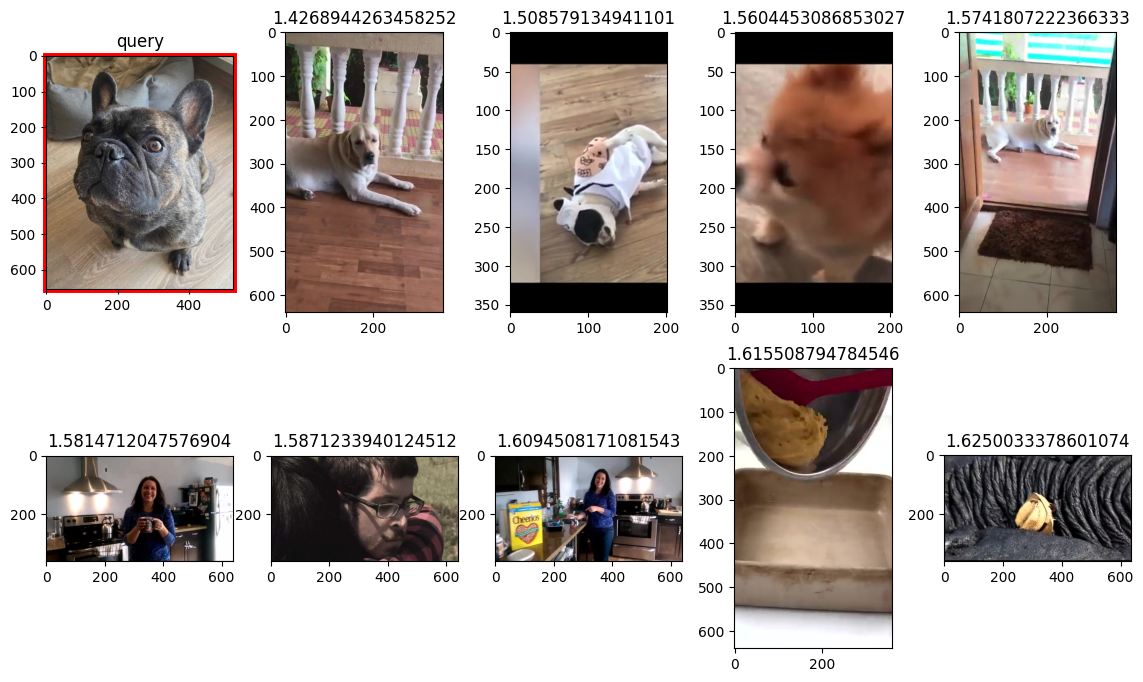

In [93]:
search_by_image('./test/george.jpg')

Best match link: https://www.youtube.com/watch?v=EqjrvrYrfQQ


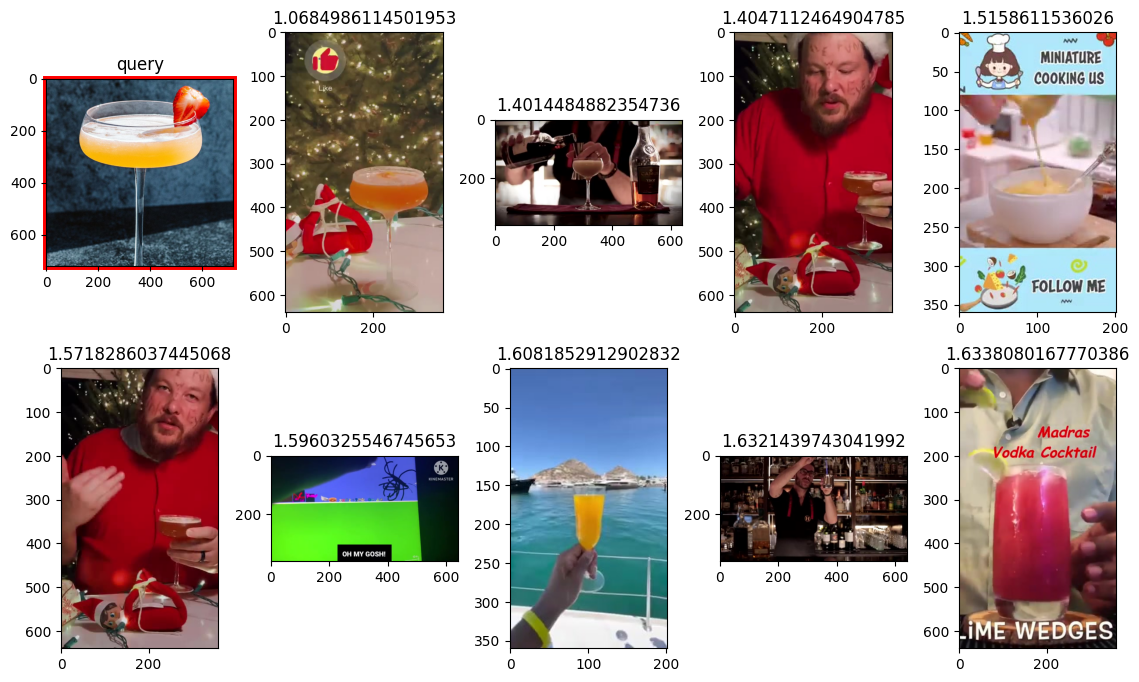

In [67]:
search_by_image('./test/cocktail.jpg')

Best match link: https://www.youtube.com/watch?v=PoSv1YS8Blk


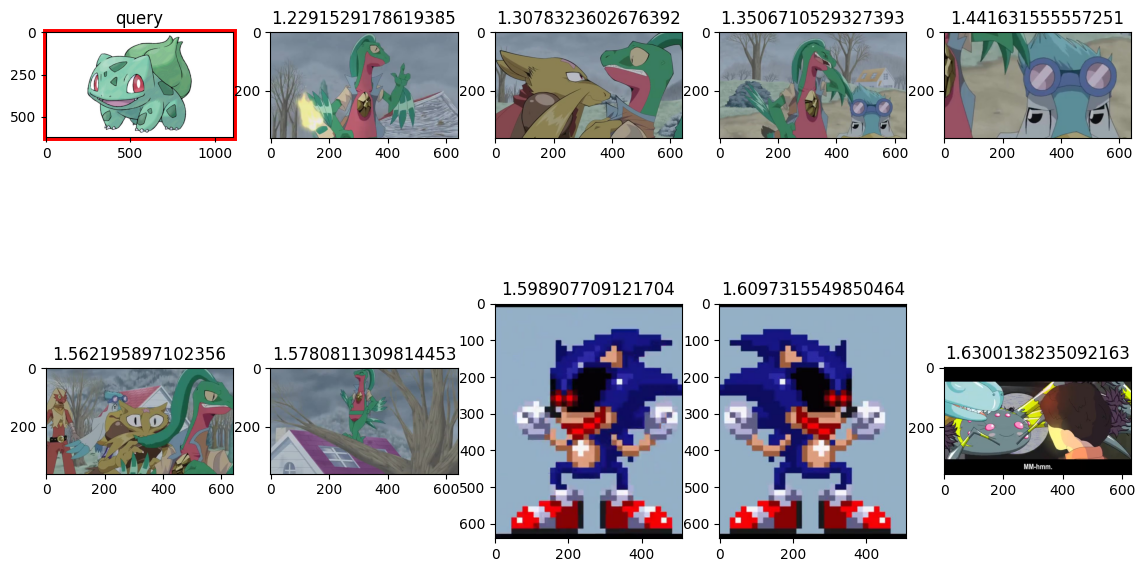

In [68]:
search_by_image('./test/pokemon.jpg')

Best match link: https://www.youtube.com/watch?v=Rcms7I-ZSkE


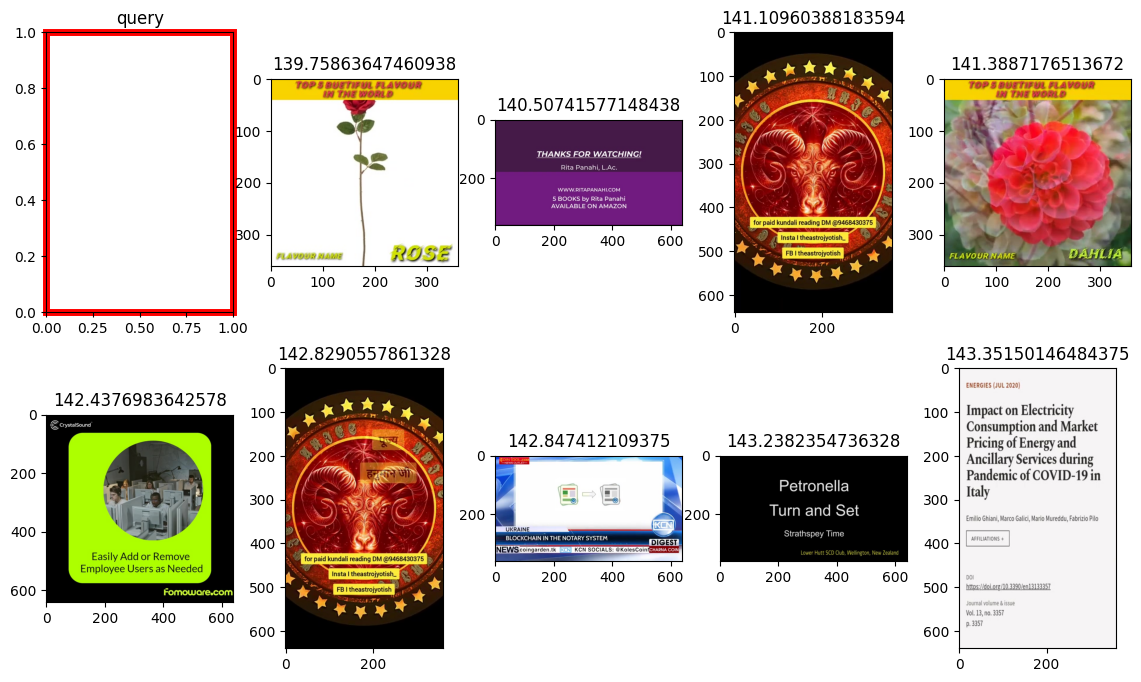

In [97]:
search_by_text('plant')

Best match link: https://www.youtube.com/watch?v=ny4QGnNtO3s


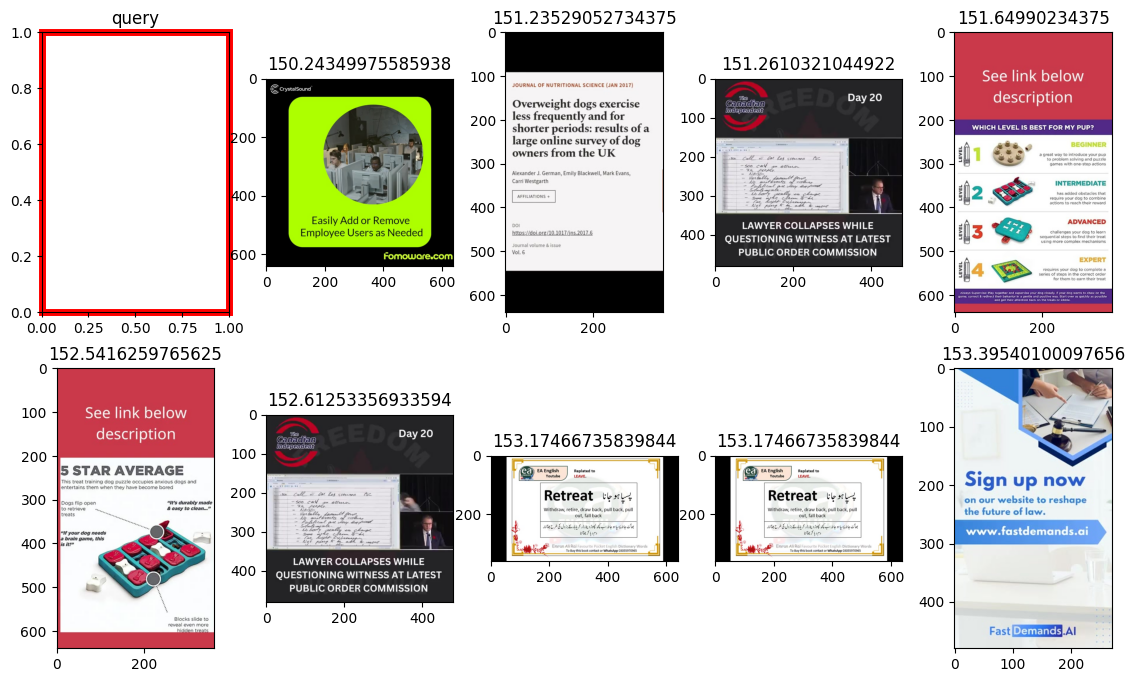

In [13]:
search_by_text('dog')

Best match link: https://www.youtube.com/watch?v=ny4QGnNtO3s


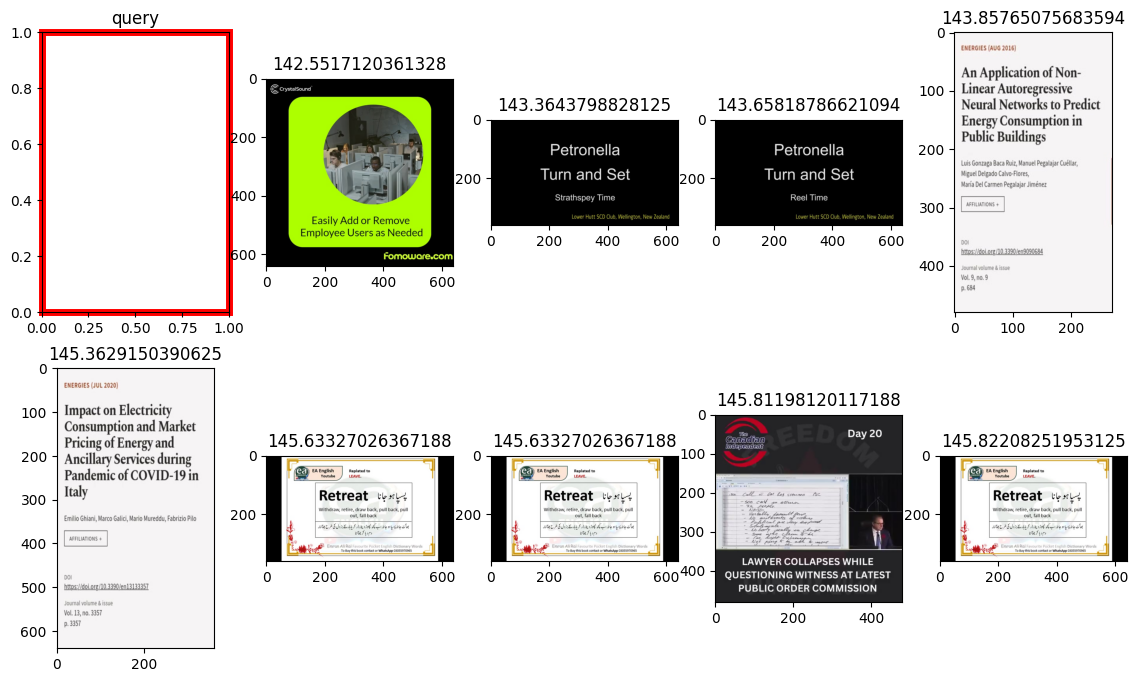

In [11]:
search_by_text('car')